In [4]:
import numpy as n
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

> ### Download the training dataset
- 1) use the DIV2K Dataset 
- 2) single-image super-resolution dataset with 1,000 images of scenes with various sorts of degradations, 
   - 800 images for training, 
   - 100 images for validation, 
   - 100 images for testing. 
- 3) We use 4x bicubic downsampled images as our "low quality" reference.

In [5]:
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

In [6]:
## To define train_data and validation_data from div2k_data
train_data = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train_data.cache()

validation_data = div2k_data.as_dataset(split="validation", as_supervised=True)
validation_cache = validation_data.cache()

>### Image Argumentation
- Flip, crip and resize images

In [7]:
def flip_left_right(lowres_img, highres_img):
    """flips images to left and right""" 
    
    rn = tf.random.uniform(shape=(), maxval=1)
    
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img)
        )
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""
    
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, high_crop_size, scale=4):
    """Crop image size
    low_res: 24 x 24
    high_res: 96 x 96"""
    
    ## for lowres image case(24)
    lowres_crop_size = high_crop_size // scale
    lowres_img_size = tf.shape(lowres_img)[:2]    # height, width
    
    lowres_height = tf.random.uniform(shape=(), maxval=lowres_img_size[0] - lowres_crop_size + 1, dtype=tf.int32)
    lowres_width = tf.random.uniform(shape=(), maxval=lowres_img_size[1] - lowres_crop_size + 1, dtype=tf.int32)
    
    ## for highres image case(96)
    highres_height = lowres_height * scale
    highres_width = lowres_width * scale
    
    ## To calculate crop image size(24 x 24)
    lowres_img_cropped = lowres_img[
        lowres_height: lowres_height + lowres_crop_size,
        lowres_width: lowres_width + lowres_crop_size
        ]
    ## To calculate crop image size(24 x 24)
    highres_img_cropped = highres_img[
        highres_height: highres_height + high_crop_size,
        highres_width: highres_width + high_crop_size
        ]
    
    print(lowres_crop_size, lowres_img_size, 
        lowres_height, lowres_width, 
        highres_height, highres_width,
        lowres_img_cropped, highres_img_cropped)
    
    return lowres_img_cropped, highres_img_cropped

>### Prepare tf.data.Dataset object
- training data with random horizontal flips and 90 rotations.
-  As low resolution images, we use 24x24 RGB input patches.

In [8]:
def dataset_object(dataset_cache, training=True):
    """Image argumentation: flip, rotate and crop"""
    
    ds = dataset_cache
    
    ## [random crop]
    ## num_parallel_calls=AUTOTUNE은 데이터 변환을 병렬로 처리하기 위한 매개변수, Tensorflow에서 자동 최적값 설정
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, high_crop_size=96, scale=4), 
        num_parallel_calls=AUTOTUNE
    )
    
    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
        
    ## Batching Data: 데이터셋을 배치로 나눈다(크기=16)
    ds = ds.batch(16)
    
    # Repeat data: 훈련하는 동안 일반적으로 에포크(epoch)를 사용하여 모델을 여러 번 훈련
    ## 이유는 이를 통해, 훈련데이터의 다양한 부분 집합을 모델이 여러 번 경험하면서 학습 가능
    if training:
        ds = ds.repeat()
        
    # 데이터 프리페칭
    ## 데이터를 미리 가져와서 현재 이미지가 처리되는 동안 이후 이미지를 미리 준비
    ## 이유는 GPU 또는 다른 연산 장치가 데이터를 처리하는 동안 CPU가 다음 데이터를 미리 로드하여 대기 가능
    ## 이로 인해 데이터 입력 파이프 라인과 모델 훈련이 효율적으로 병렬로 실행  
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds     

In [9]:
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(validation_cache, training=False)

24 Tensor("strided_slice:0", shape=(2,), dtype=int32) Tensor("random_uniform:0", shape=(), dtype=int32) Tensor("random_uniform_1:0", shape=(), dtype=int32) Tensor("mul:0", shape=(), dtype=int32) Tensor("mul_1:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(None, None, 3), dtype=uint8) Tensor("strided_slice_4:0", shape=(None, None, 3), dtype=uint8)
24 Tensor("strided_slice:0", shape=(2,), dtype=int32) Tensor("random_uniform:0", shape=(), dtype=int32) Tensor("random_uniform_1:0", shape=(), dtype=int32) Tensor("mul:0", shape=(), dtype=int32) Tensor("mul_1:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(None, None, 3), dtype=uint8) Tensor("strided_slice_4:0", shape=(None, None, 3), dtype=uint8)


>### Visualize the data

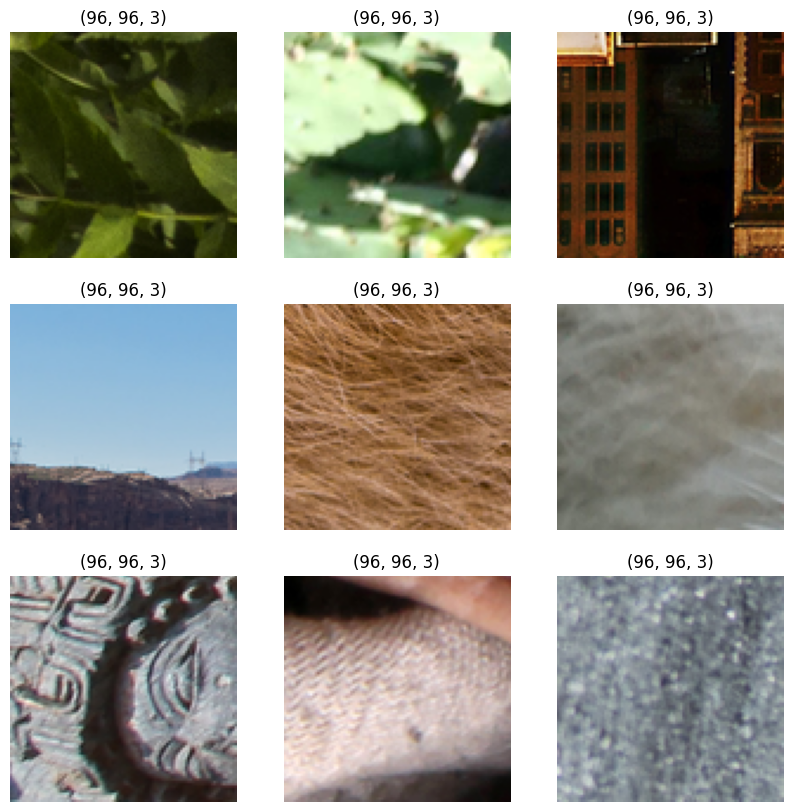

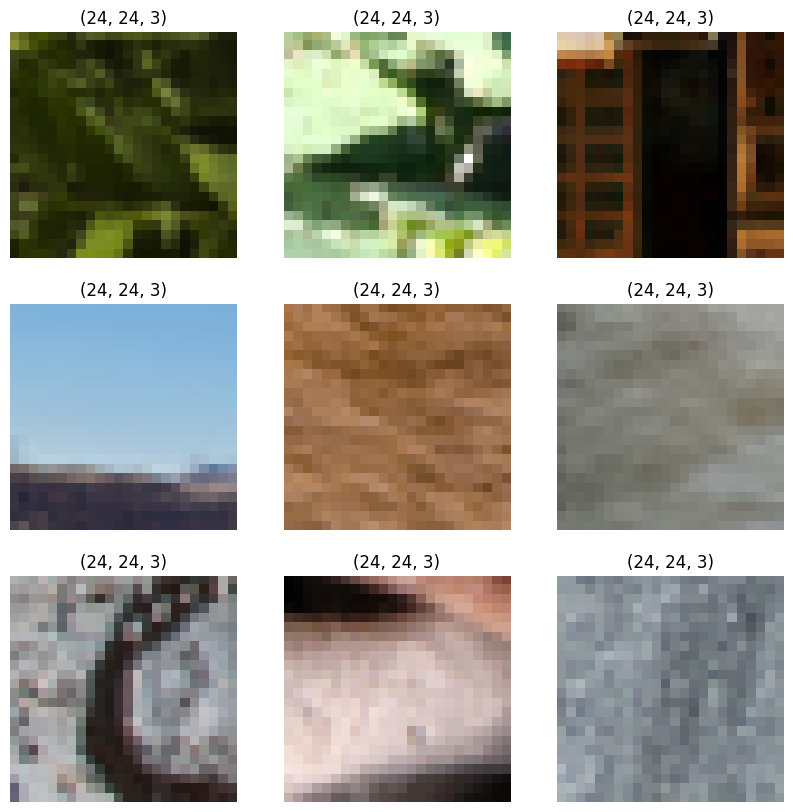

In [10]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

>### To measure quality of image

In [1]:
def PSNR(super_resolution, high_resolution):
    """compute SNR ratio"""
    ## Max value of pixel = 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    
    return psnr_value

>### Build the Model
- 